# Forecasting Lorenz with DNN

## GPU check

In [1]:
import platform
platform.platform()

'macOS-13.3-arm64-arm-64bit'

In [2]:
import tensorflow as tf
tf.__version__

'2.9.0'

In [3]:
gpu = len(tf.config.list_physical_devices("GPU"))>0
gpu

True

In [4]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Generate data

In [405]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from time import time

In [408]:
# Create a function that takes a vector as input and returns (x_dot,y_dot,z_dot) evaluated at t and rho
def lorenz(t, x, rho):
    x = np.array([10*(x[1]-x[0]),
                  x[0]*(rho-x[2])-x[1],
                  x[0]*x[1]-8/3*x[2]])
    return x

In [409]:
# Create a list of evaluation points t_eval
dt = 0.01
tf = 10
num = tf/dt
num = int(num)
t_eval = np.linspace(0,tf,int(num)).tolist()

In [410]:
# Create "random" initial values between 0 and 10
np.random.seed(0)

inits = np.random.rand(3)*10
inits = inits.tolist()

# Print these initial values for the test data set
inits

[5.4881350392732475, 7.151893663724195, 6.027633760716439]

In [411]:
sol_rho17 = solve_ivp(lorenz, [0,tf], inits, t_eval=t_eval, args=(17,))
sol_rho35 = solve_ivp(lorenz, [0,tf], inits, t_eval=t_eval, args=(35,))
sol_rho47 = solve_ivp(lorenz, [0,tf], inits, t_eval=t_eval, args=(47,))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


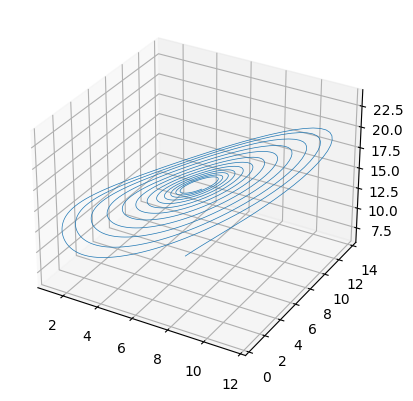

In [358]:
# Plot the data
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*sol_rho17.y, lw=0.5)
#ax.set_xlabel("X Axis")
#ax.set_ylabel("Y Axis")
#ax.set_zlabel("Z Axis")
#ax.set_title("Lorenz Attractor")
plt.savefig('lorenz_models/NewModels/LatexModels/p17s0.eps',format='eps',bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


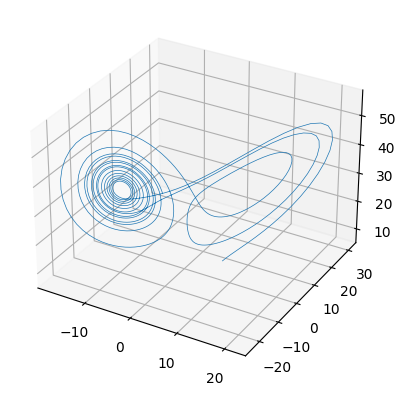

In [359]:
# Plot the data
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*sol_rho35.y, lw=0.5)
#ax.set_xlabel("X Axis")
#ax.set_ylabel("Y Axis")
#ax.set_zlabel("Z Axis")
#ax.set_title("Lorenz Attractor")
plt.savefig('lorenz_models/NewModels/LatexModels/p35s0.eps',format='eps',bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


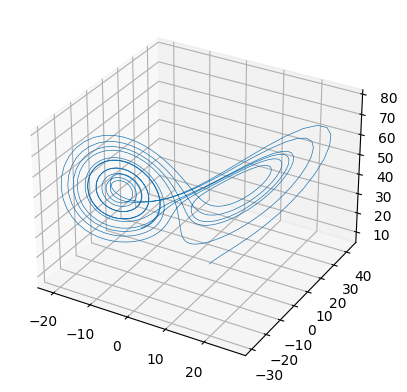

In [360]:
# Plot the data
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*sol_rho47.y, lw=0.5)
#ax.set_xlabel("X Axis")
#ax.set_ylabel("Y Axis")
#ax.set_zlabel("Z Axis")
#ax.set_title("Lorenz Attractor")
plt.savefig('lorenz_models/NewModels/LatexModels/p47s0.eps',format='eps',bbox_inches='tight')
plt.show()

## Data Preprocessing

In [412]:
rho_10 = np.matrix([17]*num)
rho_28 = np.matrix([35]*num)
rho_40 = np.matrix([47]*num)
# each with shape (num, 1)

In [413]:
X_10 = np.concatenate((sol_rho17.y.T,rho_10.T), axis=1)
X_28 = np.concatenate((sol_rho35.y.T,rho_28.T), axis=1)
X_40 = np.concatenate((sol_rho47.y.T,rho_40.T), axis=1)
X = np.concatenate((X_10,X_28,X_40),axis=0)
X = X.T
# with shape (4, 3*num)

In [414]:
# Split X into batches of size num
X1 = X[:,0:num]
X2 = X[:,num:2*num]
X3 = X[:,2*num:3*num]

fi = 10

# Build the forward iteration matrices
forward_iters1 = []
for i in range(fi):
    forward_iters1.append(X1[:,i:-fi+i])

forward_iters2 = []
for i in range(fi):
    forward_iters2.append(X2[:,i:-fi+i])

forward_iters3 = []
for i in range(fi):
    forward_iters3.append(X3[:,i:-fi+i])
    
forward_iters1 = np.array(forward_iters1)
forward_iters2 = np.array(forward_iters2)
forward_iters3 = np.array(forward_iters3)

# Transpose forward_iters so that they are readable as input data (10, 990, 4)
f1 = np.transpose(forward_iters1, axes=(0,2,1))
f2 = np.transpose(forward_iters2, axes=(0,2,1))
f3 = np.transpose(forward_iters3, axes=(0,2,1))

# used for batching
#f1 = np.transpose(f1, axes = (1,0,2))
#f2 = np.transpose(f2, axes = (1,0,2))
#f3 = np.transpose(f3, axes = (1,0,2))

## Build Keras model

In [340]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Force network to output values in double format
#tf.keras.backend.set_floatx('float32')

In [341]:
#Jason's code

def init_model(num_hidden_layers = 4, num_neurons_per_layer = 100):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is 2D - each component of the Henon output
    model.add(tf.keras.Input(4))

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('relu'),
            kernel_initializer='glorot_normal'))

    # Output is 2D - next step of Henon map
    model.add(tf.keras.layers.Dense(4))
    
    return model

## Get gradient and compute loss

In [342]:
def computeLoss(f1, f2, f3, steps, model):
    
    loss = 0

    for s in range(steps+1):
        if s == 0: 
            model_out1 = model(f1[0])
            model_out2 = model(f2[0])
            model_out3 = model(f3[0])
        else:
            model_out1 = model(model_out1)
            model_out2 = model(model_out2)
            model_out3 = model(model_out3)
        
        expected_out1 = f1[s+1]
        loss += tf.reduce_mean(tf.square(expected_out1-model_out1))/(steps+1)
        #loss += tf.reduce_mean(tf.reduce_sum(tf.square(expected_out1-model_out1), 1, keepdims=True))
        
        expected_out2 = f2[s+1]
        loss += tf.reduce_mean(tf.square(expected_out2-model_out2))/(steps+1)
        #loss += tf.reduce_mean(tf.reduce_sum(tf.square(expected_out2-model_out2), 1, keepdims=True))
        
        expected_out3 = f3[s+1]
        loss += tf.reduce_mean(tf.square(expected_out3-model_out3))/(steps+1)
        #loss += tf.reduce_mean(tf.reduce_sum(tf.square(expected_out3-model_out3), 1, keepdims=True))
        
    return loss 
    

In [343]:
def trainStep(f1, f2, f3, opt, steps, model):
    
    # Gradient tape for model parameters
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        
        # Compute the loss associated to current model
        loss = computeLoss(f1, f2, f3, steps, model)
        
    # Compute the gradient of loss wrt model parameters
    grads = tape.gradient(loss, model.trainable_variables)
    
    # Gradient step
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

## Main training loop

In [344]:
def trainLoop(f1, f2, f3, epochs, steps, model):
    
    # Define an optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000,5000],[1e-2,1e-3,1e-4])
    #lr = tf.keras.optimizers.schedules.PolynomialDecay(0.1, epochs, 1e-4)
    #lr = 0.001
    opt = keras.optimizers.Adam(lr)
    
    # Define an empty numpy array to hold the loss at each epoch
    epoch_loss = np.zeros(epochs)
    
    '''
    # Data preprocessing (for batching)
    batch_size = 5
    
    # Splits the data into batches of size batch_size
    data_sample1 = tf.data.Dataset.from_tensor_slices(f1)
    data_sample1 = data_sample.cache().shuffle(10).batch(batch_size)
    
    data_sample2 = tf.data.Dataset.from_tensor_slices(f2)
    data_sample2 = data_sample.cache().shuffle(10).batch(batch_size)
    
    data_sample3 = tf.data.Dataset.from_tensor_slices(f3)
    data_sample3 = data_sample.cache().shuffle(10).batch(batch_size)
    
    # ds is made to hold the batches and prefetch minimizes the step time
    ds1 = tf.data.Dataset.zip((data_sample1))
    ds1 = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    ds2 = tf.data.Dataset.zip((data_sample2))
    ds2 = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    ds3 = tf.data.Dataset.zip((data_sample3))
    ds3 = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    for (j1,j2,j3) in zip(ds1,ds2,ds3):
            
            j1 = tf.cast(j1, dtype=tf.float32)
            j2 = tf.cast(j2, dtype=tf.float32)
            j3 = tf.cast(j3, dtype=tf.float32)
    
    '''
    
    # Main training loop
    for i in range(epochs):

        # Compute the loss and add to the total loss in the epoch
        PDEloss = trainStep(f1, f2, f3, opt, steps, model)
        epoch_loss[i] += PDEloss

        # Print the loss at each epoch
        if np.mod(i, 100) == 0 or i == 9999:
            print("Loss in {}th epoch: {: 1.4e}.".format(i, epoch_loss[i]))

    return epoch_loss

## Define epochs and train network

In [346]:
# Initialize the timer
model2 = init_model(num_hidden_layers = 4, num_neurons_per_layer = 100)

# Start timer
t0 = time()

# Define number of epochs and run training loop
epochs = 10000
steps = 4
loss = trainLoop(f1, f2, f3, epochs, steps, model2)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Loss in 0th epoch:  1.9227e+03.
Loss in 100th epoch:  8.4855e+01.
Loss in 200th epoch:  4.0784e+01.
Loss in 300th epoch:  2.2736e+01.
Loss in 400th epoch:  1.3887e+01.
Loss in 500th epoch:  8.7670e+00.
Loss in 600th epoch:  1.1015e+01.
Loss in 700th epoch:  6.6079e+00.
Loss in 800th epoch:  4.6808e+00.
Loss in 900th epoch:  5.6023e+00.
Loss in 1000th epoch:  2.4244e+00.
Loss in 1100th epoch:  1.7221e+00.
Loss in 1200th epoch:  1.1231e+00.
Loss in 1300th epoch:  2.5895e+00.
Loss in 1400th epoch:  4.0671e+00.
Loss in 1500th epoch:  3.4590e+00.
Loss in 1600th epoch:  2.6934e+00.
Loss in 1700th epoch:  9.9783e-01.
Loss in 1800th epoch:  2.5944e+00.
Loss in 1900th epoch:  1.6542e+00.
Loss in 2000th epoch:  1.7668e+00.
Loss in 2100th epoch:  5.2140e-01.
Loss in 2200th epoch:  5.0924e-01.
Loss in 2300th epoch:  4.9821e-01.
Loss in 2400th epoch:  4.8822e-01.
Loss in 2500th epoch:  4.7898e-01.
Loss in 2600th epoch:  4.7007e-01.
Loss in 2700th epoch:  4.6162e-01.
Loss in 2800th epoch:  4.5362e-0

## Plot loss over epochs

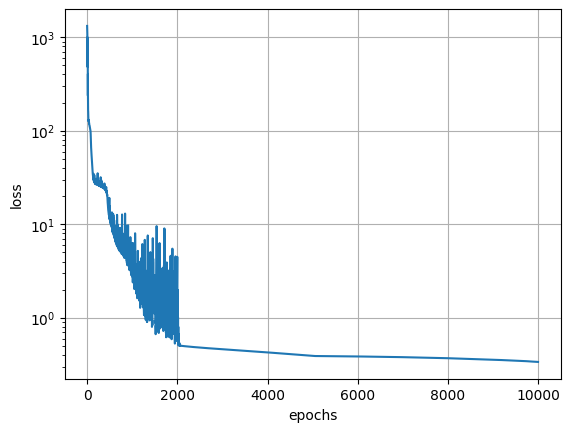

In [221]:
plt.semilogy(range(0, epochs), loss)

plt.ylabel('loss')
plt.xlabel('epochs')
plt.grid()
plt.savefig('lorenz_models/NewModels/LatexModels/model_s=4_H=20_L=4_Relu100_loss.eps',format='eps',bbox_inches='tight')
plt.show()

## Visualize Results

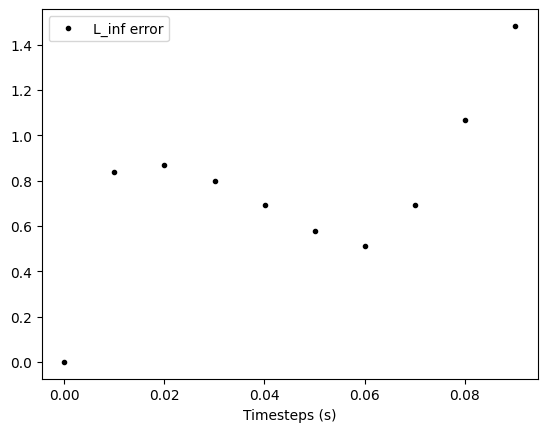

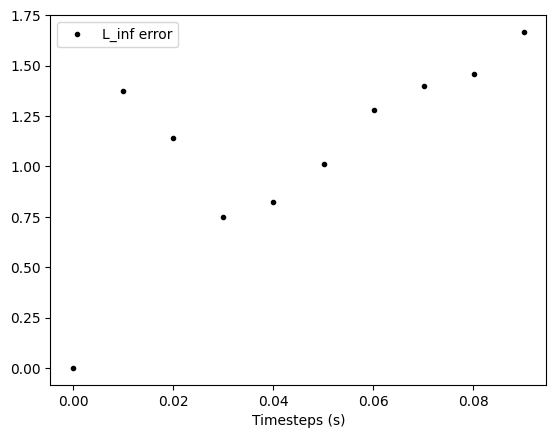

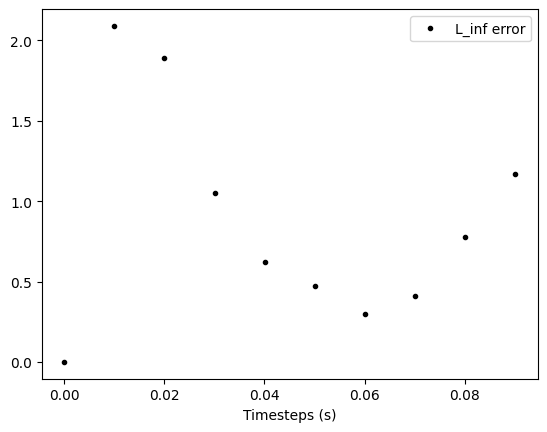

In [418]:
y17 = np.amax(abs(sol_rho17.y-data17),axis=0)

plt.xlabel('Timesteps (s)')
plt.plot(t_eval[0:10],y17[0:10], 'k.', label='L_inf error')
plt.savefig('lorenz_models/NewModels/LatexModels/Relu17_acc.eps',format='eps',bbox_inches='tight')
plt.legend()
plt.show()

y35 = np.amax(abs(sol_rho35.y-data35),axis=0)

plt.xlabel('Timesteps (s)')
plt.plot(t_eval[0:10],y35[0:10], 'k.', label='L_inf error')
plt.savefig('lorenz_models/NewModels/LatexModels/Relu35_acc.eps',format='eps',bbox_inches='tight')
plt.legend()
plt.show()

y47 = np.amax(abs(sol_rho47.y-data47),axis=0)

plt.xlabel('Timesteps (s)')
plt.plot(t_eval[0:10],y47[0:10], 'k.', label='L_inf error')
plt.savefig('lorenz_models/NewModels/LatexModels/Relu47_acc.eps',format='eps',bbox_inches='tight')
plt.legend()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


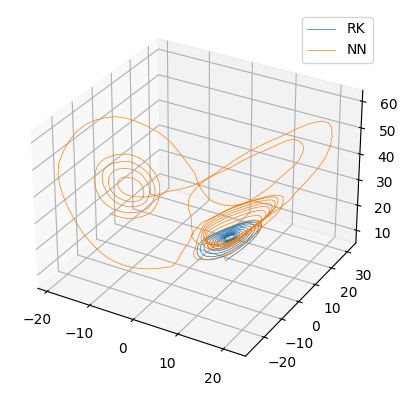

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


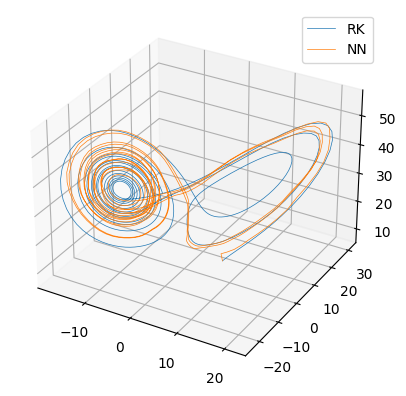

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


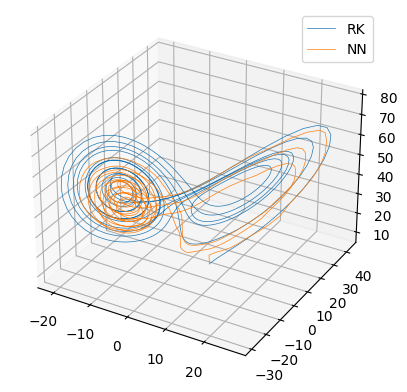

In [415]:
# Build the network approximations for the final data
first_pass17 = np.append(inits,17)
first_pass35 = np.append(inits,35)
first_pass47 = np.append(inits,47)

X_gen17 = np.zeros((num,4))
X_gen17[0] = first_pass17

X_gen35 = np.zeros((num,4))
X_gen35[0] = first_pass35

X_gen47 = np.zeros((num,4))
X_gen47[0] = first_pass47

for j in range(1,num):
    X_gen17[j] = model2(X_gen17[j-1:j,:])
    X_gen35[j] = model2(X_gen35[j-1:j,:])
    X_gen47[j] = model2(X_gen47[j-1:j,:])
    
# Transpose data and remove row of rhos
data17 = X_gen17.T[0:3]
data35 = X_gen35.T[0:3]
data47 = X_gen47.T[0:3]

ax = plt.figure().add_subplot(projection='3d')
ax.plot(*sol_rho17.y, lw=0.5, label='RK')
ax.plot(*data17, lw=0.5, label='NN')
plt.savefig('lorenz_models/NewModels/LatexModels/Relu17.eps',format='eps',bbox_inches='tight')
plt.legend()
plt.show()

ax = plt.figure().add_subplot(projection='3d')
ax.plot(*sol_rho35.y, lw=0.5, label='RK')
ax.plot(*data35, lw=0.5, label='NN')
plt.savefig('lorenz_models/NewModels/LatexModels/Relu35.eps',format='eps',bbox_inches='tight')
plt.legend()
plt.show()

ax = plt.figure().add_subplot(projection='3d')
ax.plot(*sol_rho47.y, lw=0.5, label='RK')
ax.plot(*data47, lw=0.5, label='NN')
plt.savefig('lorenz_models/NewModels/LatexModels/Relu47.eps',format='eps',bbox_inches='tight')
plt.legend()
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


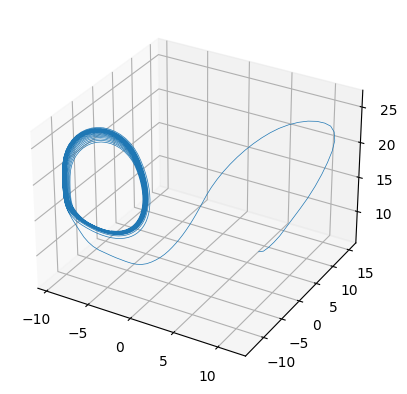

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


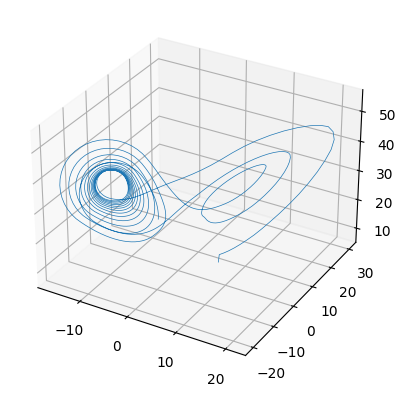

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


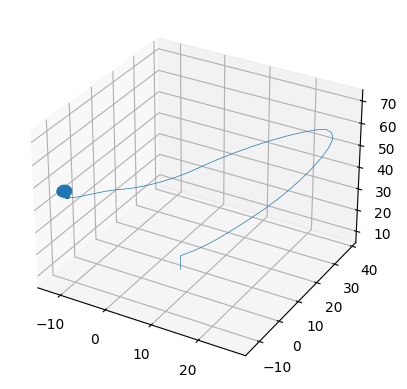

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


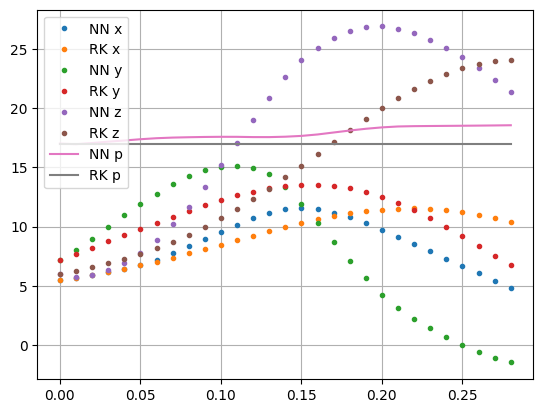

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


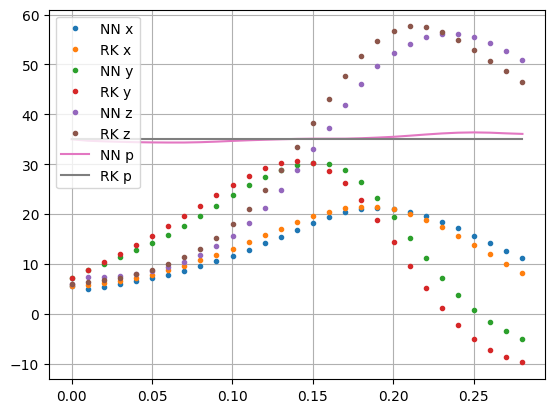

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


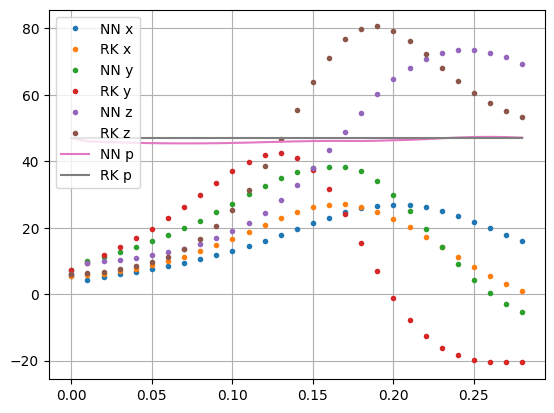

In [337]:
# Create the starting feed for the network
first_pass10 = np.append(inits,17)
first_pass28 = np.append(inits,35)
first_pass40 = np.append(inits,47)

X_gen10 = np.zeros((num,4))
X_gen10[0] = first_pass10

X_gen28 = np.zeros((num,4))
X_gen28[0] = first_pass28

X_gen40 = np.zeros((num,4))
X_gen40[0] = first_pass40

for j in range(1,num):
    X_gen10[j] = model2(X_gen10[j-1:j,:])
    X_gen28[j] = model2(X_gen28[j-1:j,:])
    X_gen40[j] = model2(X_gen40[j-1:j,:])
    
# Transpose data and remove row of rhos
data10 = X_gen10.T[0:3]

# Plot the data
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*data10, lw=0.5)
plt.savefig('lorenz_models/NewModels/LatexModels/Relu17.eps',format='eps',bbox_inches='tight')
plt.show()

data28 = X_gen28.T[0:3]

ax = plt.figure().add_subplot(projection='3d')

ax.plot(*data28, lw=0.5)
plt.savefig('lorenz_models/NewModels/LatexModels/Relu35.eps',format='eps',bbox_inches='tight')
plt.show()

data40 = X_gen40.T[0:3]

ax = plt.figure().add_subplot(projection='3d')

ax.plot(*data40, lw=0.5)
plt.savefig('lorenz_models/NewModels/LatexModels/Relu47.eps',format='eps',bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()

ax.plot(t_eval[0:29], X_gen10[0:29,0],'.', label='NN x')
ax.plot(t_eval[0:29], X1.T[0:29,0],'.', label='RK x')

ax.plot(t_eval[0:29], X_gen10[0:29,1],'.', label='NN y')
ax.plot(t_eval[0:29], X1.T[0:29,1],'.', label='RK y')

ax.plot(t_eval[0:29], X_gen10[0:29,2],'.', label='NN z')
ax.plot(t_eval[0:29], X1.T[0:29,2],'.', label='RK z')

ax.plot(t_eval[0:29], X_gen10[0:29,3], label='NN p')
ax.plot(t_eval[0:29], X1.T[0:29,3], label='RK p')

plt.xlabel('')
plt.legend(loc = 'upper left')
plt.grid()
plt.savefig('lorenz_models/NewModels/LatexModels/Relu17_accuracy.eps',format='eps',bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()

ax.plot(t_eval[0:29], X_gen28[0:29,0],'.', label='NN x')
ax.plot(t_eval[0:29], X2.T[0:29,0],'.', label='RK x')

ax.plot(t_eval[0:29], X_gen28[0:29,1],'.', label='NN y')
ax.plot(t_eval[0:29], X2.T[0:29,1],'.', label='RK y')

ax.plot(t_eval[0:29], X_gen28[0:29,2],'.', label='NN z')
ax.plot(t_eval[0:29], X2.T[0:29,2],'.', label='RK z')

ax.plot(t_eval[0:29], X_gen28[0:29,3], label='NN p')
ax.plot(t_eval[0:29], X2.T[0:29,3], label='RK p')

plt.xlabel('')
plt.legend(loc = 'upper left')
plt.grid()
plt.savefig('lorenz_models/NewModels/LatexModels/Relu35_accuracy.eps',format='eps',bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()

ax.plot(t_eval[0:29], X_gen40[0:29,0],'.', label='NN x')
ax.plot(t_eval[0:29], X3.T[0:29,0],'.', label='RK x')

ax.plot(t_eval[0:29], X_gen40[0:29,1],'.', label='NN y')
ax.plot(t_eval[0:29], X3.T[0:29,1],'.', label='RK y')

ax.plot(t_eval[0:29], X_gen40[0:29,2],'.', label='NN z')
ax.plot(t_eval[0:29], X3.T[0:29,2],'.', label='RK z')

ax.plot(t_eval[0:29], X_gen40[0:29,3], label='NN p')
ax.plot(t_eval[0:29], X3.T[0:29,3], label='RK p')

plt.xlabel('')
plt.legend(loc = 'upper left')
plt.grid()
plt.savefig('lorenz_models/NewModels/LatexModels/Relu47_accuracy.eps',format='eps',bbox_inches='tight')
plt.show()

## Save the model and initial conditions

In [251]:
# Save results
#!mkdir -p lorenz_models
model2.save('lorenz_models/NewModels/Relu100')
np.save('lorenz_models/NewModels/Relu100', inits)

INFO:tensorflow:Assets written to: lorenz_models/NewModels/Relu100/assets


## Load saved model

In [404]:
#saved_inits = np.load('lorenz_models/NewModels/LatexModels/SELU/Selu/saved_model.pb')
#print(saved_inits)

model2 = tf.keras.models.load_model('lorenz_models/NewModels/LatexModels/RELU/Relu')
saved_model.summary()

AttributeError: 'int' object has no attribute 'keras'

## Compile the model and forecast some data if loading from file

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


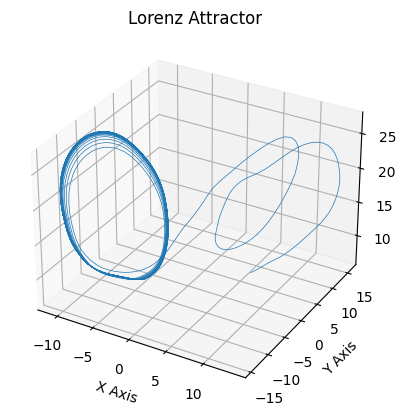

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


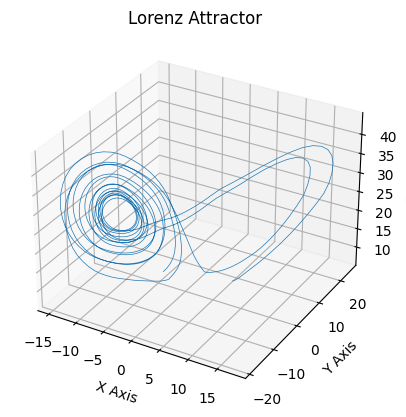

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


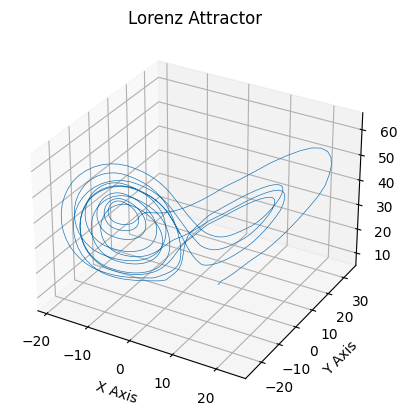

In [146]:
saved_model.compile()

# Create the starting feed for the network
first_pass10 = np.append(saved_inits,10)
first_pass28 = np.append(saved_inits,28)
first_pass40 = np.append(saved_inits,40)

X_gen10 = np.zeros((num,4))
X_gen10[0] = first_pass10

X_gen28 = np.zeros((num,4))
X_gen28[0] = first_pass28

X_gen40 = np.zeros((num,4))
X_gen40[0] = first_pass40

for j in range(1,num):
    X_gen10[j] = saved_model(X_gen10[j-1:j,:])
    X_gen28[j] = saved_model(X_gen28[j-1:j,:])
    X_gen40[j] = saved_model(X_gen40[j-1:j,:])
    
# Transpose data and remove row of rhos
data10 = X_gen10.T[0:3]

# Plot the data
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*data10, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.savefig('/Users/samir/Documents/Winter2023/MAST680/Assignment3/lorenz_models/NewModels/model_s=2_H=30_L=4_rho=10.eps', format='eps')
plt.show()

data28 = X_gen28.T[0:3]

ax = plt.figure().add_subplot(projection='3d')

ax.plot(*data28, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.savefig('/Users/samir/Documents/Winter2023/MAST680/Assignment3/lorenz_models/NewModels/model_s=2_H=30_L=4_rho=28.eps', format='eps')
plt.show()

data40 = X_gen40.T[0:3]

ax = plt.figure().add_subplot(projection='3d')

ax.plot(*data40, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.savefig('/Users/samir/Documents/Winter2023/MAST680/Assignment3/lorenz_models/NewModels/model_s=2_H=30_L=4_rho=40.eps', format='eps')
plt.show()

## Compare with Runge Kutta method (optimized numerical integrator)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


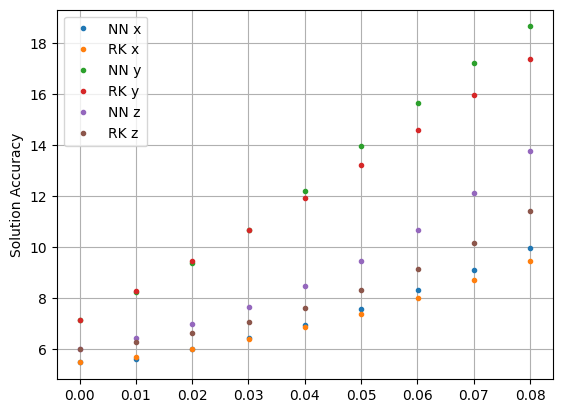

In [33]:
fig, ax = plt.subplots()

ax.plot(t_eval[0:9], X_gen28[0:9,0],'.', label='NN x')
ax.plot(t_eval[0:9], X2.T[0:9,0],'.', label='RK x')

ax.plot(t_eval[0:9], X_gen28[0:9,1],'.', label='NN y')
ax.plot(t_eval[0:9], X2.T[0:9,1],'.', label='RK y')

ax.plot(t_eval[0:9], X_gen28[0:9,2],'.', label='NN z')
ax.plot(t_eval[0:9], X2.T[0:9,2],'.', label='RK z')

plt.ylabel('Solution Accuracy')
plt.xlabel('')
plt.legend(loc = 'upper left')
plt.grid()
plt.savefig('/Users/samir/Documents/Winter2023/MAST680/Assignment3/lorenz_models/NewModels/model_s=0_H=10_L=4_rho=28_Acc.eps', format='eps')
plt.show()